In [1]:
import numpy
import numpy as np
import time
import datetime
import netCDF4
import matplotlib.pylab as plt
import os,sys,glob
from multiprocessing import Pool
#import odb
from eccodes import *
from functools import partial
from collections import OrderedDict
import subprocess
import json
import gzip
import copy
import pickle
import xarray as xr
import pickle
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt
matplotlib.rcParams.update({'font.size': 20})

plt.rcParams['lines.linewidth'] = 3

import warnings
warnings.filterwarnings('ignore')

sys.path.append(os.getcwd()+'/../../cds-backend/code/')
import cds_eua4 as eua
sys.path.append(os.getcwd()+'/..')
import trajectory as trj

import h5py
import ray
import pyproj
# ray.init(num_cpus=7)


no config found


In [2]:

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def datetime_to_seconds(dates, ref='1900-01-01T00:00:00'):
    """ from datetime64 to seconds since 1900-01-01 00:00:00"""
    return ((dates - np.datetime64(ref)) / np.timedelta64(1, 's')).astype(np.int64)

def seconds_to_datetime(seconds, ref='1900-01-01'):
    """ from seconds to datetime64 """
    seconds = np.asarray(seconds)
    return pd.to_datetime(seconds, unit='s', origin=ref)

# Projection Types

In [3]:
a = [1,2,23,5,6,7]
np.cumsum(a)

array([ 1,  3, 26, 31, 37, 44])

In [4]:
def par_read_bufr_stn_nofeedback_mre_interp(varno,bufrfile):
    pltcount = 0
    alldata=''
    alldict=dict()

    bufrlist=[]
    tx=time.time()
#     try:
    f = open(bufrfile)
    print(f)
    cnt = 0
    output = {}
    # loop over the messages in the file
    bc = 0
    

    plev_vals = {}    
    rmse_sum_lon_s={}
    rmse_sum_lat_s={}
    rmse_sum_lon_sr={}
    rmse_sum_lat_sr={}
    rmse_sum_lon_sri={}
    rmse_sum_lat_sri={}

    stdplevs = [100000,92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]

    for i in stdplevs:
        plev_vals[i] = []
        rmse_sum_lon_s[i] = []
        rmse_sum_lat_s[i] = []
        rmse_sum_lon_sr[i] = []
        rmse_sum_lat_sr[i] = []
        rmse_sum_lon_sri[i] = []
        rmse_sum_lat_sri[i] = []

        
    while 1:
#         try:
        # get handle for message
        bufr = codes_bufr_new_from_file(f)
        if bufr is None:
            break
        # we need to instruct ecCodes to expand all the descriptors
        # i.e. unpack the data section
#         print (codes_get_array(bufr,'dataSubCategory'))
        if codes_get_array(bufr,'dataSubCategory')[0]!=109:
#             print('not 109')
            codes_release(bufr)
            continue
        codes_set(bufr, 'unpack', 1)
        # get all the timePeriods
        iterid = codes_bufr_keys_iterator_new(bufr)
#         print('iterid ', iterid)

        # loop over the keys
        #if codes_get_array(bufr,'dataSubCategory')[0]!=101:
#         print (codes_get_array(bufr,'dataSubCategory')[0])
            #codes_release(bufr)
            #continue
        hires=False
        while codes_bufr_keys_iterator_next(iterid):

#             print key name
            keyname = codes_bufr_keys_iterator_get_name(iterid)
#                 print(keyname,codes_get_array(bufr,keyname))
            #if keyname in ['#1#blockNumber','#1#stationNumber']:
                #print (keyname,codes_get_array(bufr,keyname))
            if 'latitudeDisplacement' in keyname:
                hires=True
        if not hires:
            codes_bufr_keys_iterator_delete(iterid)
            codes_release(bufr)
            continue
        ## delete the key iterator
        codes_bufr_keys_iterator_delete(iterid)
        output['datum'] = float(codes_get_array(bufr, "typicalDate")[0])
#             if str(output['datum'])[4:6] != '12':
#                 codes_release(bufr)
#                 continue
        output['timePeriod'] = float(codes_get_array(bufr, "typicalTime")[0])
        output['pressure'] = codes_get_array(bufr, "pressure")
        output['extendedVerticalSoundingSignificance'] = codes_get_array(bufr, "extendedVerticalSoundingSignificance")
        output['geopotentialHeight'] = codes_get_array(bufr, "nonCoordinateGeopotentialHeight")
        output['latitudeDisplacement'] = codes_get_array(bufr, "latitudeDisplacement")
        output['longitudeDisplacement'] = codes_get_array(bufr, "longitudeDisplacement")
        output['airTemperature'] = codes_get_array(bufr, "airTemperature")
        dewpointTemperature = codes_get_array(bufr, "dewpointTemperature")
        output['windDirection'] = codes_get_array(bufr, "windDirection")
        output['windSpeed'] = codes_get_array(bufr, "windSpeed")
        output['lat'] = codes_get(bufr, "latitude")
        output['lon'] = codes_get(bufr, "longitude")
        output['alt'] = float(codes_get(bufr, "heightOfStation"))
        output['blockNumber'] = codes_get(bufr, "blockNumber")
        output['stationNumber'] = codes_get(bufr, "stationNumber")
        try:
            out = pd.DataFrame.from_dict(output)
            cont = True
        except:
            cont = False
            
        if cont:
            # try:
            out = out[out.airTemperature < 350]
            out = out[out.airTemperature > 180]

            out['u'] = out.windSpeed * np.cos(np.radians(270.0 - out.windDirection))
            out['v'] = out.windSpeed * np.sin(np.radians(270.0 - out.windDirection))

            reduced_out = out[np.isin(out.pressure, stdplevs)]
            if len(reduced_out) < 5:
                continue
                
            if (np.abs(np.nanmean(out.longitudeDisplacement)) < 0.001) or (np.abs(np.nanmean(out.latitudeDisplacement)) < 0.001) or (np.max(np.abs(out.latitudeDisplacement)) > 10):
                continue
            
            if (len(out) < 0) or (len(reduced_out) < 3):
                continue
                
            num_p = 20
            p_list = np.linspace(out.pressure.iloc[0], out.pressure.iloc[-1], num=num_p)
            true_p_list = list(reduced_out.pressure)
            for i in p_list:
                true_p_list.append(find_nearest(out.pressure, i))
            interpolated_reduced_out = out[np.isin(out.pressure, true_p_list)]
            # display(interpolated_reduced_out)
            # display(reduced_out)
            u_new = []
            v_new = []
            # print(interpolated_reduced_out.pressure, np.flip(reduced_out.pressure), np.flip(reduced_out.u))
            # print((np.interp(interpolated_reduced_out.pressure, np.flip(reduced_out.pressure), np.flip(reduced_out.u))))
            
            # u_new = (np.interp(interpolated_reduced_out.pressure, np.flip(reduced_out.pressure), np.flip(reduced_out.u)))
            # v_new = (np.interp(interpolated_reduced_out.pressure, np.flip(reduced_out.pressure), np.flip(reduced_out.v)))
            
            for k in range(len(interpolated_reduced_out)):
                if reduced_out.pressure.iloc[0] >= interpolated_reduced_out.pressure.iloc[k] >= reduced_out.pressure.iloc[-1]:
                    u_new.append(np.interp(interpolated_reduced_out.pressure.iloc[k], np.flip(reduced_out.pressure), np.flip(reduced_out.u)))
                    v_new.append(np.interp(interpolated_reduced_out.pressure.iloc[k], np.flip(reduced_out.pressure), np.flip(reduced_out.v)))
                else:
                    u_new.append(np.nan)
                    v_new.append(np.nan)

            u = np.array(u_new)
            v = np.array(v_new)
            interpolated_reduced_out['ip_u'] = u
            interpolated_reduced_out['ip_v'] = v
            interpolated_reduced_out = interpolated_reduced_out.dropna(subset=['ip_u', 'ip_v'])
                
            reduced_interp_sph_lat_disp, reduced_interp_sph_lon_disp, sph_rts = trj.trajectory(
                lat=out.lat.iloc[0], lon=out.lon.iloc[0],
                temperature=np.array(interpolated_reduced_out.airTemperature), u=np.array(interpolated_reduced_out.ip_u), v=np.array(interpolated_reduced_out.ip_v),
                pressure=np.array(interpolated_reduced_out.pressure),
                # output='km',
                transport_type='sphere')
            # reduced_interp_sph_lat_disp = np.cumsum(reduced_interp_sph_lat_disp)
            # reduced_interp_sph_lon_disp = np.cumsum(reduced_interp_sph_lon_disp)
            
            # print(reduced_interp_sph_lat_disp, reduced_interp_sph_lon_disp)

            sph_lat_disp, sph_lon_disp, sph_rts = trj.trajectory(
                lat=out.lat.iloc[0], lon=out.lon.iloc[0],
                temperature=np.array(out.airTemperature), u=np.array(out.u), v=np.array(out.v),
                pressure=np.array(out.pressure),
                # output='km',
                transport_type='sphere')
            # sph_lat_disp = np.cumsum(sph_lat_disp)
            # sph_lon_disp = np.cumsum(sph_lon_disp)

            reduced_sph_lat_disp, reduced_sph_lon_disp, reduced_sph_rts = trj.trajectory(
                lat=reduced_out.lat.iloc[0], lon=reduced_out.lon.iloc[0],
                temperature=np.array(reduced_out.airTemperature), u=np.array(reduced_out.u), v=np.array(reduced_out.v),
                pressure=np.array(reduced_out.pressure),
                # output='km',
                transport_type='sphere')
            # reduced_sph_lat_disp = np.cumsum(reduced_sph_lat_disp)
            # reduced_sph_lon_disp = np.cumsum(reduced_sph_lon_disp)

            ell_lat_disp, ell_lon_disp, ell_rts = trj.trajectory(
                lat=out.lat.iloc[0], lon=out.lon.iloc[0],
                temperature=np.array(out.airTemperature), u=np.array(out.u), v=np.array(out.v),
                pressure=np.array(out.pressure),
                # output='km',
                transport_type='geod')
            # ell_lat_disp = np.cumsum(ell_lat_disp)
            # ell_lon_disp = np.cumsum(ell_lon_disp)

            reduced_ell_lat_disp, reduced_ell_lon_disp, reduced_ell_rts = trj.trajectory(
                lat=reduced_out.lat.iloc[0], lon=reduced_out.lon.iloc[0],
                temperature=np.array(reduced_out.airTemperature), u=np.array(reduced_out.u), v=np.array(reduced_out.v),
                pressure=np.array(reduced_out.pressure),
                # output='km',
                transport_type='geod')
            # reduced_ell_lat_disp = np.cumsum(reduced_ell_lat_disp)
            # reduced_ell_lon_disp = np.cumsum(reduced_ell_lon_disp)
            

            for i in stdplevs:
                try:
                    rmse_sum_lon_s[i].append(
                        float(np.abs(np.array(sph_lon_disp)[out.pressure == i] - 
                              out[out.pressure == i].longitudeDisplacement.values)
                        / (np.abs(out[out.pressure == i].longitudeDisplacement.values))
                    ))
                    rmse_sum_lat_s[i].append(
                        float(np.abs(np.array(sph_lat_disp)[out.pressure == i] - 
                              out[out.pressure == i].latitudeDisplacement.values) 
                        / (np.abs(out[out.pressure == i].latitudeDisplacement.values))
                    ))
                    rmse_sum_lon_sr[i].append(
                        float(np.abs(np.array(reduced_sph_lon_disp)[reduced_out.pressure == i] - 
                              reduced_out[reduced_out.pressure == i].longitudeDisplacement.values) 
                        / (np.abs(reduced_out[reduced_out.pressure == i].longitudeDisplacement.values))
                    ))
                    rmse_sum_lat_sr[i].append(
                        float(np.abs(np.array(reduced_sph_lat_disp)[reduced_out.pressure == i] - 
                              reduced_out[reduced_out.pressure == i].latitudeDisplacement.values) 
                        / (np.abs(reduced_out[reduced_out.pressure == i].latitudeDisplacement.values))
                    ))
                    rmse_sum_lon_sri[i].append(
                        float(np.abs(np.array(reduced_interp_sph_lon_disp)[interpolated_reduced_out.pressure == i] - 
                              interpolated_reduced_out[interpolated_reduced_out.pressure == i].longitudeDisplacement.values) 
                        / (np.abs(reduced_out[reduced_out.pressure == i].longitudeDisplacement.values))
                    ))
                    rmse_sum_lat_sri[i].append(
                        float(np.abs(np.array(reduced_interp_sph_lat_disp)[interpolated_reduced_out.pressure == i] - 
                              interpolated_reduced_out[interpolated_reduced_out.pressure == i].latitudeDisplacement.values) 
                        / (np.abs(reduced_out[reduced_out.pressure == i].latitudeDisplacement.values))
                    ))
                    plev_vals[i].append(1)
                except:
                    rmse_sum_lon_s[i].append(np.nan)
                    rmse_sum_lat_s[i].append(np.nan)
                    rmse_sum_lon_sr[i].append(np.nan)
                    rmse_sum_lat_sr[i].append(np.nan)
                    rmse_sum_lon_sri[i].append(np.nan)
                    rmse_sum_lat_sri[i].append(np.nan)
                    plev_vals[i].append(0)
                    
            if (pltcount % 20) == 0:
                startlat = out.lat.iloc[0]
                startlon = out.lon.iloc[0]

                print('length of input data:',len(out))
                print('significant levels:',len(reduced_out))
                print('lat: ',out.lat.iloc[0], '   lon: ', out.lon.iloc[0])
                print('date: ', out.datum.iloc[0], '   time: ', out.timePeriod.iloc[0])
                # display(interpolated_reduced_out)
                fig, ax1 = maplt.subplots(figsize=(15, 9))
                ax1.set_yscale('log')
                # ax1.plot(np.array(reduced_interp_sph_lat_disp), interpolated_reduced_out.pressure, color = 'green', alpha = 1, linewidth= 1, label='ri sphere calc lat disp')
                # ax1.plot(np.array(reduced_interp_sph_lon_disp), interpolated_reduced_out.pressure, color = 'brown', alpha = 1, linewidth= 1, label='ri sphere calc lon disp')
                
                sph_dist = []
                for i in range(len(out.latitudeDisplacement)):
                    dist_i = trj.haversine(startlat, startlon, startlat + sph_lat_disp[i], startlon + sph_lon_disp[i])
                    sph_dist.append(dist_i)

                ax1.plot(np.array(sph_dist), out.pressure,color = 'black', alpha = 1, linewidth= 2, label='sphere calc displacement')
                # ax1.plot(np.array(sph_lon_disp),out.pressure,color = 'brown', alpha = 1, linewidth= 2, label='sphere calc lon disp')

                ell_dist = []
                for i in range(len(out.latitudeDisplacement)):
                    dist_i = trj.haversine(startlat, startlon, startlat + sph_lat_disp[i], startlon + sph_lon_disp[i])
                    ell_dist.append(dist_i)
                ax1.plot(np.array(ell_dist), out.pressure,color = 'blue', alpha = 0.2, linewidth= 10, label='geod calc displacement')
                # ax1.plot(np.array(ell_lon_disp),out.pressure,color = 'red', alpha = 0.2, linewidth= 10, label='geod calc lon disp')

#                 ax1.plot(np.array(reduced_sph_lat_disp), reduced_out.pressure,color = 'black', alpha = 1, linewidth= 1, label='reduced sphere calc lat disp')
#                 ax1.plot(np.array(reduced_sph_lon_disp),reduced_out.pressure,color = 'orange', alpha = 1, linewidth= 1, label='reduced sphere calc lon disp')

#                 ax1.plot(np.array(reduced_ell_lat_disp), reduced_out.pressure,color = 'cyan', alpha = 0.3, linewidth= 6, label='reduced geod calc lat disp')
#                 ax1.plot(np.array(reduced_ell_lon_disp),reduced_out.pressure,color = 'orange', alpha = 0.3, linewidth= 6, label='reduced geod calc lon disp')

                #                 plt.plot(reduced.pressure,np.array(reduced_lat_displacement),color = 'cyan', alpha = 0.7, label='reduced calc lat disp')
                #                 plt.plot(reduced.pressure,np.array(reduced_lon_displacement),color = 'orange', alpha = 0.7, label='reduced calc lon disp')
                
                orig_dist = []
                for i in range(len(out.latitudeDisplacement)):
                    dist_i = trj.haversine(startlat, startlon, startlat + out.latitudeDisplacement.iloc[i], startlon + out.longitudeDisplacement.iloc[i])
                    orig_dist.append(dist_i)

                ax1.plot(orig_dist,out.pressure,color = 'blue', label='original displacement')
                # ax1.plot(out.longitudeDisplacement,out.pressure, color = 'red', label='original lon disp')

                ax1.set_ylabel('pressure (Pa)')
                ax1.set_xlabel('displacement (km)')
                ax1.tick_params(axis='x')
                ax1.set_ylim(ax1.get_ylim()[::-1])
                ax1.legend(loc='upper left', bbox_to_anchor=(1, 0.5))

                # ax1_2 = ax1.twiny()
                # ax1_2.set_yscale('log')
                # ax1_2.plot(out.u,out.pressure, color = 'green', alpha = 0.3, label='u')
                # ax1_2.plot(out.v,out.pressure, color = 'orange', alpha = 0.3, label='v')

                fig.tight_layout()  # otherwise the right y-label is slightly clipped
                maplt.title('Comparison of Projection Types')
                maplt.legend()
                # maplt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
                maplt.grid()
                maplt.show()
                maplt.close()
            pltcount += 1
            
            # except: 
            #     pass
            # break
            if pltcount > 300:
                break
    
    limit = [5,95]
    for i in stdplevs:
        
        rmse_sum_lat_s[i] = np.array(rmse_sum_lat_s[i])
        rmse_sum_lon_s[i] = np.array(rmse_sum_lon_s[i])
        rmse_sum_lat_sr[i] = np.array(rmse_sum_lat_sr[i])
        rmse_sum_lon_sr[i] = np.array(rmse_sum_lon_sr[i])
        rmse_sum_lat_sri[i] = np.array(rmse_sum_lat_sri[i])
        rmse_sum_lon_sri[i] = np.array(rmse_sum_lon_sri[i])
        
        outlier_drop = np.nanpercentile(rmse_sum_lat_s[i], limit)
        rmse_sum_lat_s[i][rmse_sum_lat_s[i] < outlier_drop[0]] = np.nan
        rmse_sum_lat_s[i][rmse_sum_lat_s[i] > outlier_drop[1]] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_lon_s[i], limit)
        rmse_sum_lon_s[i][rmse_sum_lon_s[i] < outlier_drop[0]] = np.nan
        rmse_sum_lon_s[i][rmse_sum_lon_s[i] > outlier_drop[1]] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_lat_sr[i], limit)
        rmse_sum_lat_sr[i][rmse_sum_lat_sr[i] < outlier_drop[0]] = np.nan
        rmse_sum_lat_sr[i][rmse_sum_lat_sr[i] > outlier_drop[1]] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_lon_sr[i], limit)
        rmse_sum_lon_sr[i][rmse_sum_lon_sr[i] < outlier_drop[0]] = np.nan
        rmse_sum_lon_sr[i][rmse_sum_lon_sr[i] > outlier_drop[1]] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_lat_sri[i], limit)
        rmse_sum_lat_sri[i][rmse_sum_lat_sri[i] < outlier_drop[0]] = np.nan
        rmse_sum_lat_sri[i][rmse_sum_lat_sri[i] > outlier_drop[1]] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_lon_sri[i], limit)
        rmse_sum_lon_sri[i][rmse_sum_lon_sri[i] < outlier_drop[0]] = np.nan
        rmse_sum_lon_sri[i][rmse_sum_lon_sri[i] > outlier_drop[1]] = np.nan
    
    rmse_lat_s = []
    rmse_lon_s = []
    rmse_lat_sr = []
    rmse_lon_sr = []
    rmse_lat_sri = []
    rmse_lon_sri = []
    for i in stdplevs:
        # rmse_lat_s.append(np.sqrt(np.nanmean((rmse_sum_lat_s[i])**2)))
        # rmse_lon_s.append(np.sqrt(np.nanmean((rmse_sum_lon_s[i])**2)))
        # rmse_lat_sr.append(np.sqrt(np.nanmean((rmse_sum_lat_sr[i])**2)))
        # rmse_lon_sr.append(np.sqrt(np.nanmean((rmse_sum_lon_sr[i])**2)))
        # rmse_lat_sri.append(np.sqrt(np.nanmean((rmse_sum_lat_sri[i])**2)))
        # rmse_lon_sri.append(np.sqrt(np.nanmean((rmse_sum_lon_sri[i])**2)))
        
        rmse_lat_s.append(np.nanmean(rmse_sum_lat_s[i]))
        rmse_lon_s.append(np.nanmean(rmse_sum_lon_s[i]))
        rmse_lat_sr.append(np.nanmean(rmse_sum_lat_sr[i]))
        rmse_lon_sr.append(np.nanmean(rmse_sum_lon_sr[i]))
        rmse_lat_sri.append(np.nanmean(rmse_sum_lat_sri[i]))
        rmse_lon_sri.append(np.nanmean(rmse_sum_lon_sri[i]))

    
    fig, ax1 = maplt.subplots(1, 3, figsize = (15,10))
    ax1[0].set_yscale('log')
    ax1[1].set_yscale('log')
    ax1[0].plot(np.array(rmse_lat_s), stdplevs, color = 'blue', alpha = 0.3, label = 'lat MRE spher disp')
    ax1[0].plot(np.array(rmse_lat_sr), stdplevs, color = 'blue', label = 'lat MRE reduced spher disp')
    ax1[0].plot(np.array(rmse_lat_sri), stdplevs, color = 'green', label = 'lat MRE interp reduced spher disp')
    ax1[0].set_ylim(ax1[0].get_ylim()[::-1])
    ax1[0].set_ylabel('pressure (Pa)')
    ax1[0].set_xlabel('Mean relative error of displacement')
    ax1[0].legend(loc='upper center')
    ax1[0].grid()
    
    
    ax1[1].plot(np.array(rmse_lon_s), stdplevs, color = 'red', alpha = 0.3, label = 'lon MRE spher disp')
    ax1[1].plot(np.array(rmse_lon_sr), stdplevs, color = 'red', label = 'lon MRE reduced spher disp')
    ax1[1].plot(np.array(rmse_lon_sri), stdplevs, color = 'orange', label = 'lon MRE interp reduced spher disp')
    ax1[1].set_ylim(ax1[1].get_ylim()[::-1])
    ax1[1].set_ylabel('pressure (Pa)')
    ax1[1].set_xlabel('Mean relative error of displacement')
    ax1[1].legend(loc='upper center')
    ax1[1].grid()
    
    value_nr = []
    for i in plev_vals:
        value_nr.append(np.sum(plev_vals[i]))
    ax1[2].barh(stdplevs, value_nr, np.array(stdplevs)*7, color='g', alpha = 0.4, align='center')
    ax1[2].set_ylim(ax1[2].get_ylim()[::-1])
    ax1[2].set_xlabel('Number of Values')
    ax1[2].tick_params(labelleft=False)
    ax1[2].grid()
    
    maplt.title('LEVEL MRE for Displacement')
    maplt.show()
    maplt.close()
    
    return out

<_io.TextIOWrapper name='/users/staff/leo/ectrans/era5.bufr.202006' mode='r' encoding='UTF-8'>
length of input data: 931
significant levels: 5
lat:  52.21    lon:  14.120000000000001
date:  20200531.0    time:  224500.0


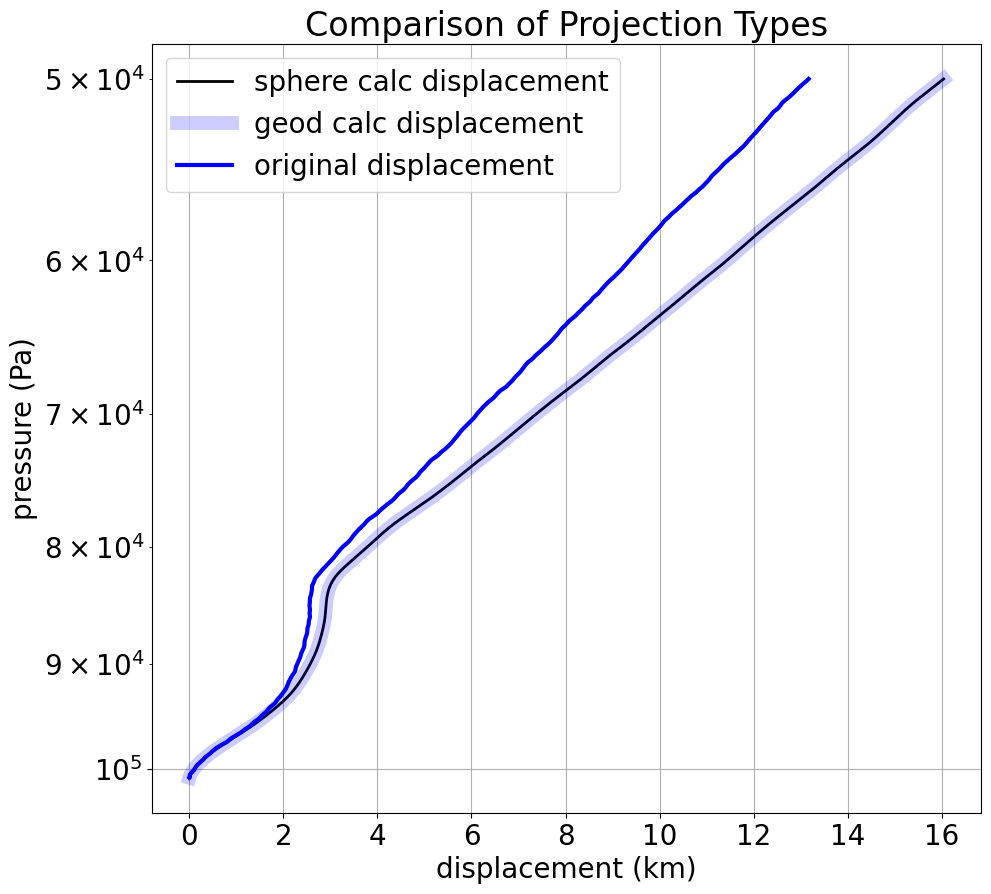

length of input data: 1440
significant levels: 10
lat:  48.24    lon:  11.55
date:  20200531.0    time:  224500.0


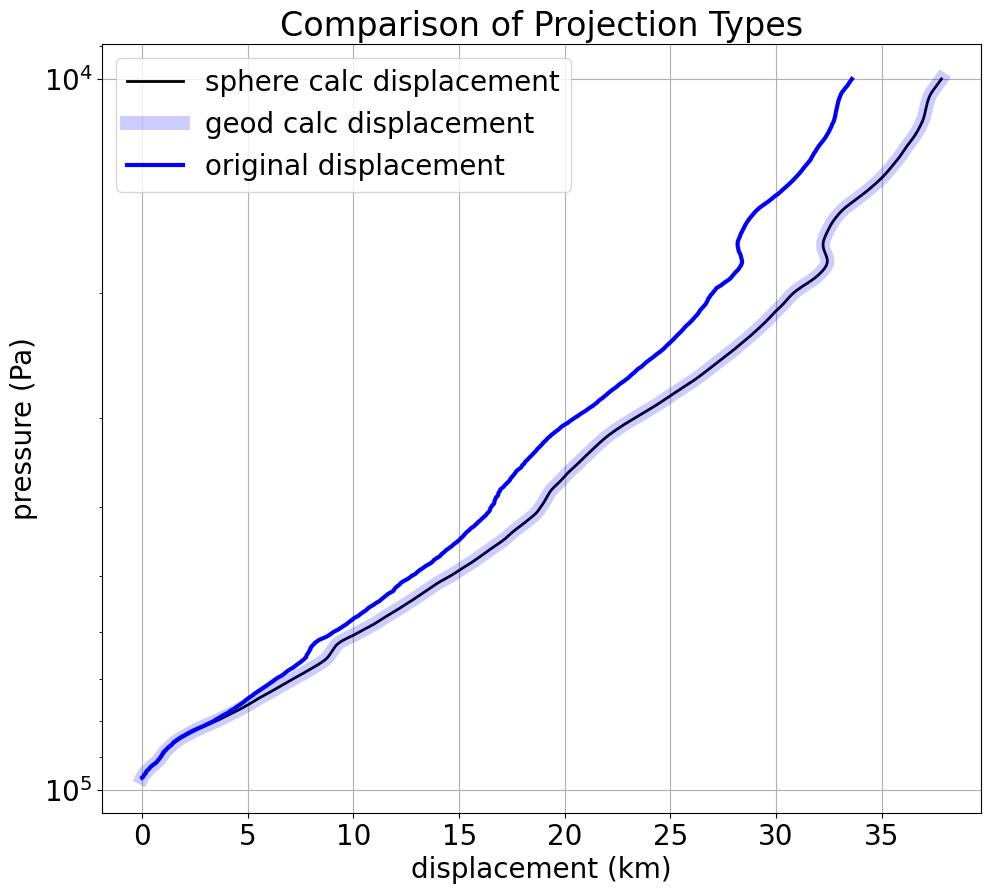

length of input data: 1744
significant levels: 11
lat:  51.410000000000004    lon:  6.970000000000001
date:  20200531.0    time:  224500.0


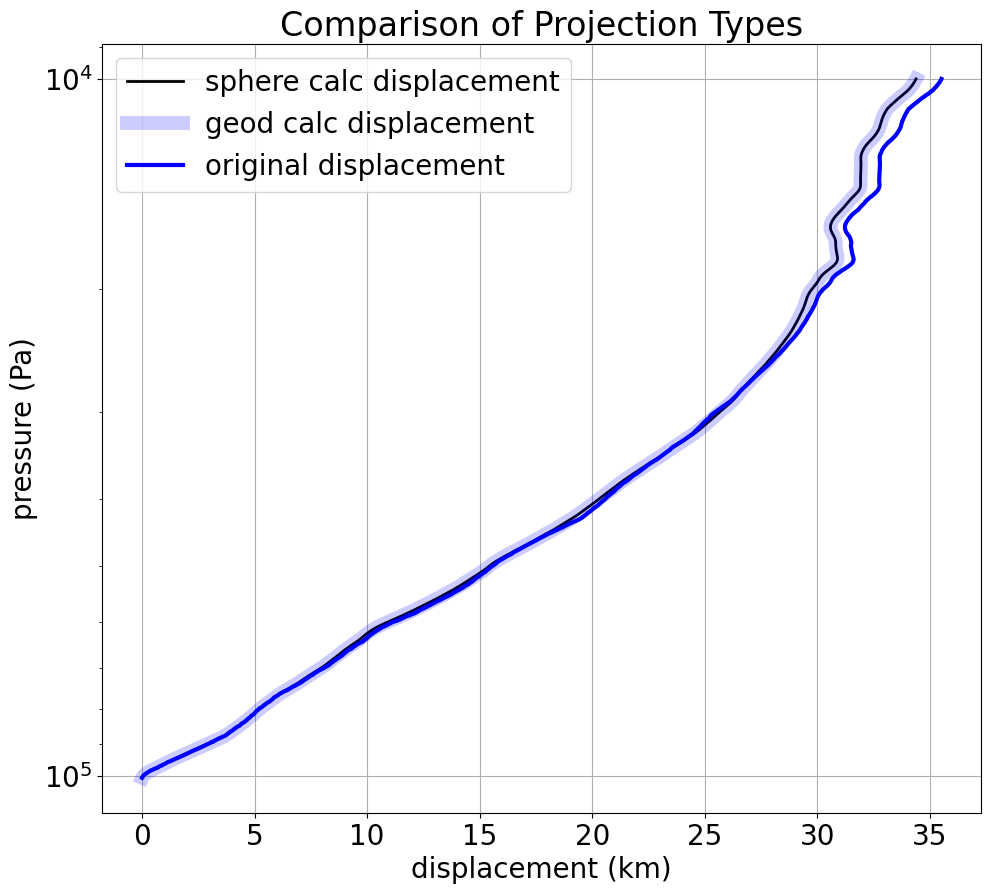

length of input data: 1332
significant levels: 13
lat:  49.45    lon:  17.130000000000003
date:  20200531.0    time:  231500.0


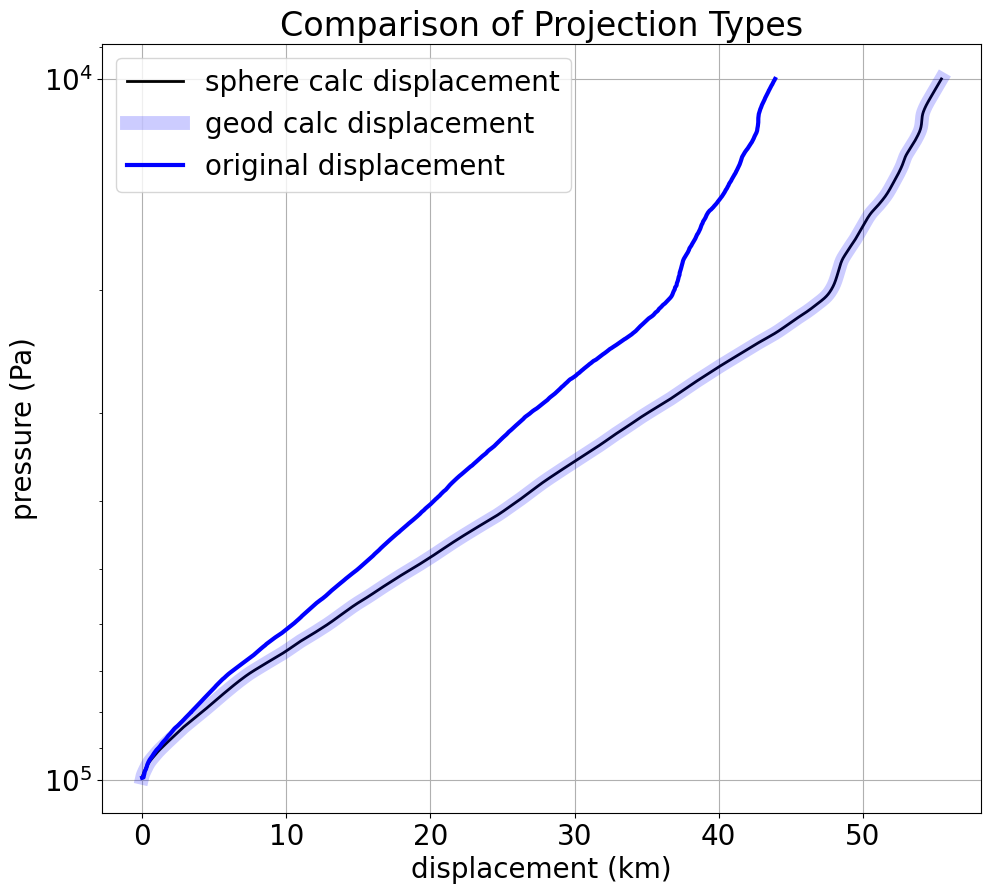

length of input data: 3357
significant levels: 8
lat:  36.25    lon:  -86.56
date:  20200531.0    time:  230000.0


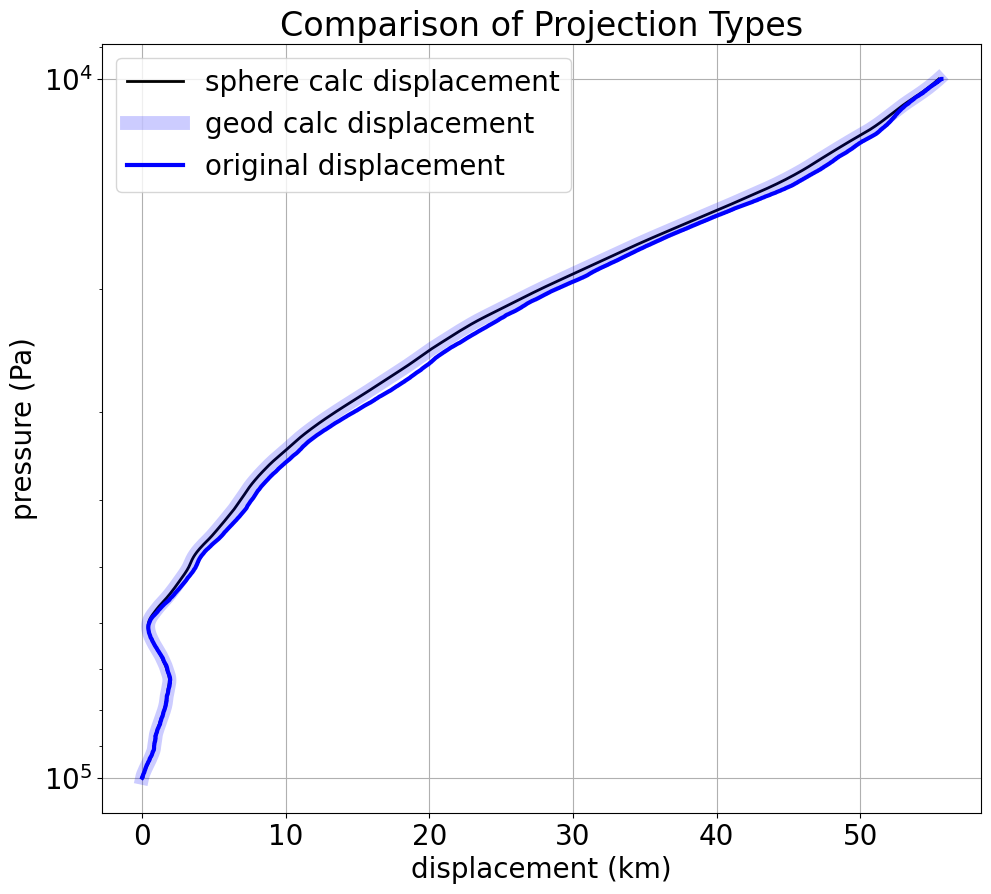

length of input data: 3330
significant levels: 7
lat:  40.77    lon:  -111.95
date:  20200531.0    time:  230300.0


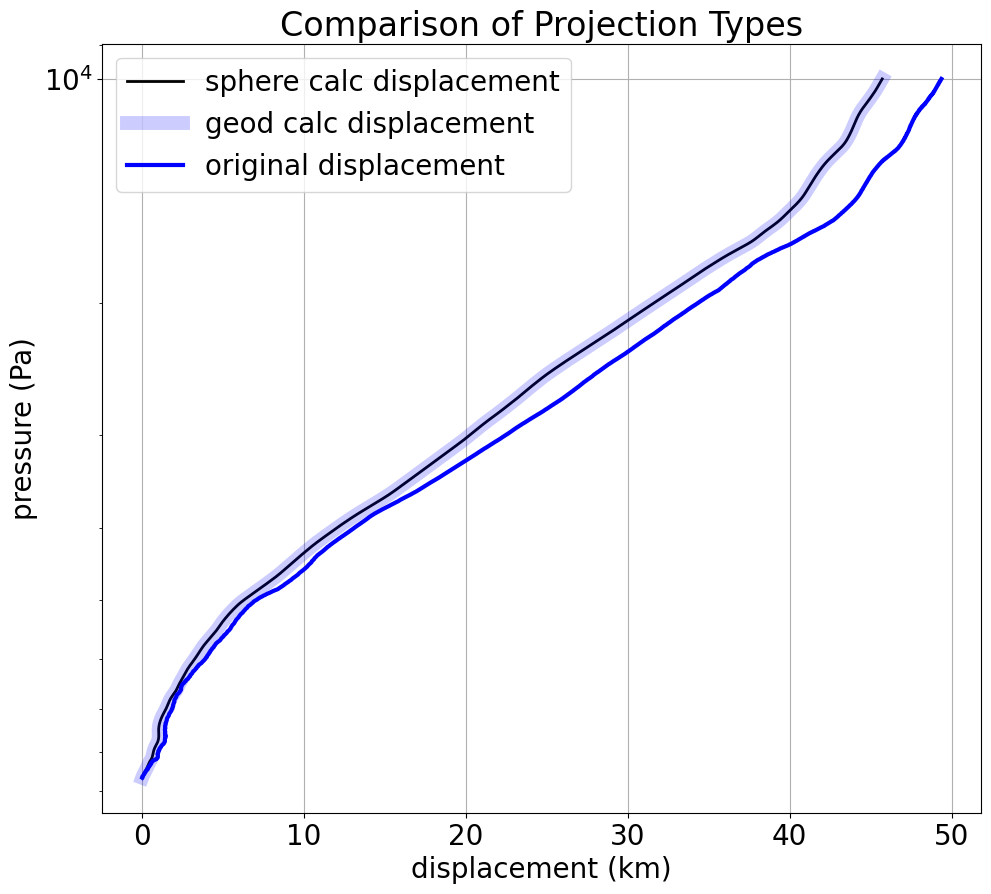

length of input data: 1727
significant levels: 11
lat:  -66.28    lon:  110.52000000000001
date:  20200531.0    time:  231500.0


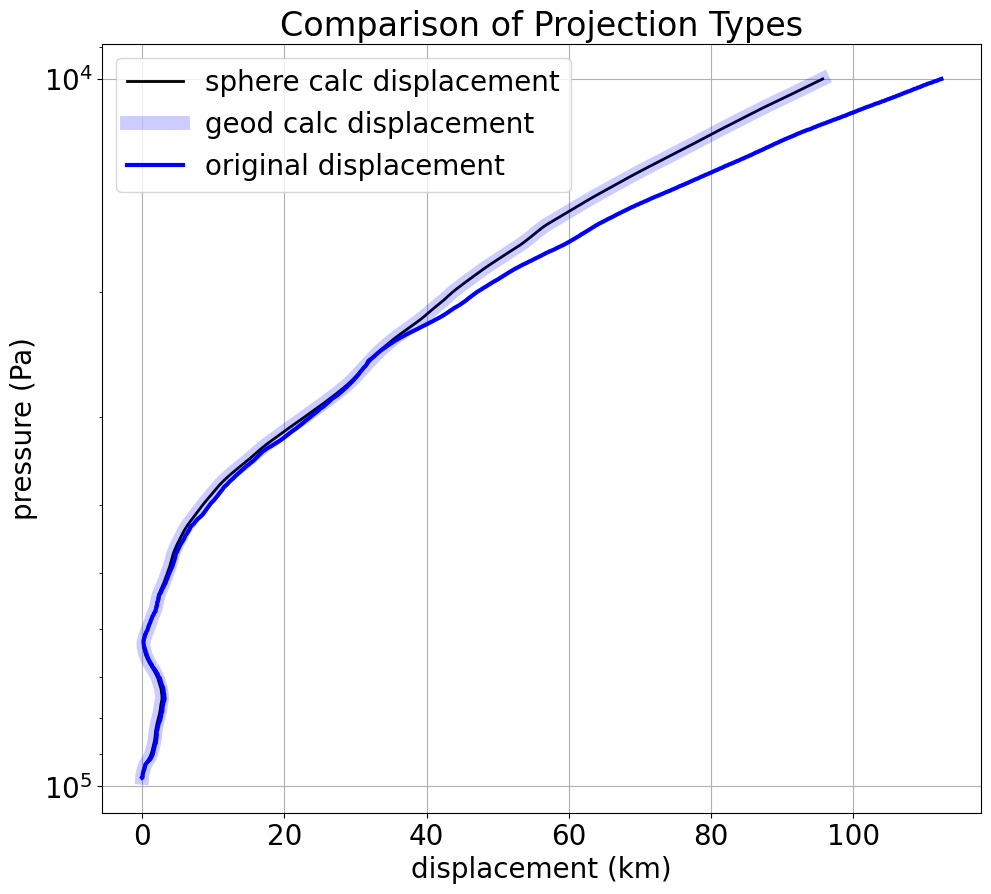

length of input data: 2589
significant levels: 15
lat:  33.45    lon:  135.76000000000002
date:  20200531.0    time:  233200.0


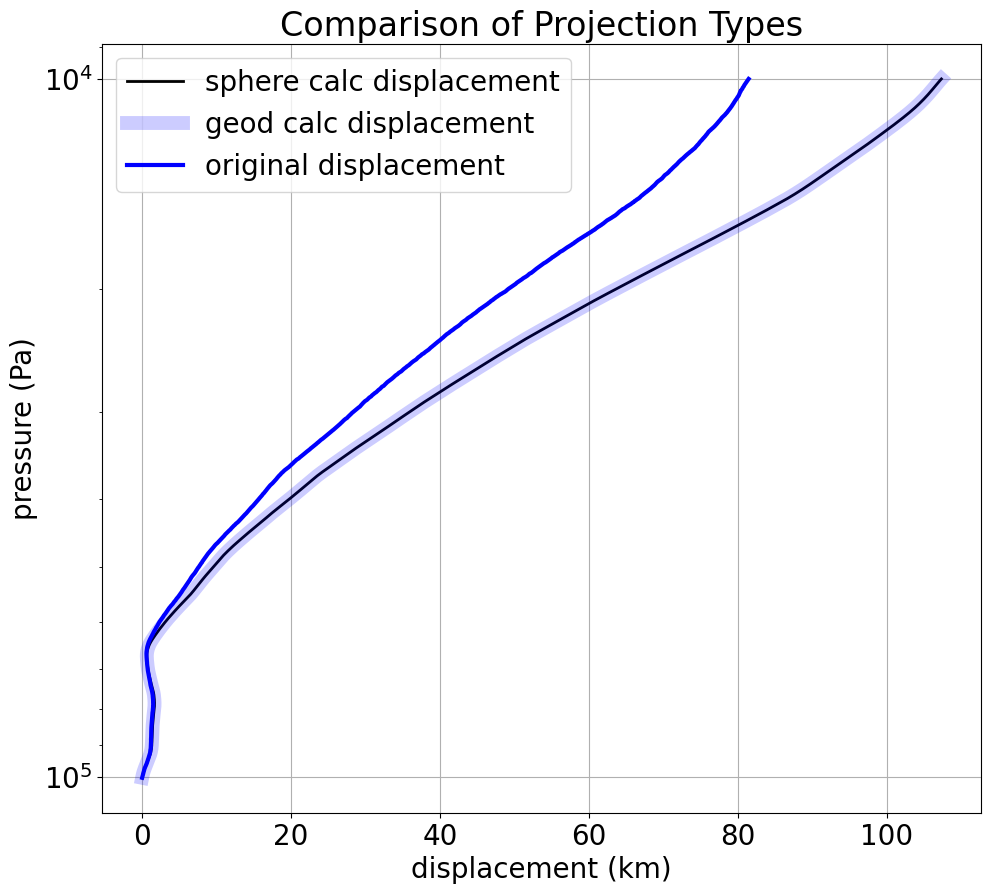

length of input data: 3599
significant levels: 11
lat:  30.450000000000003    lon:  -84.30000000000001
date:  20200531.0    time:  231900.0


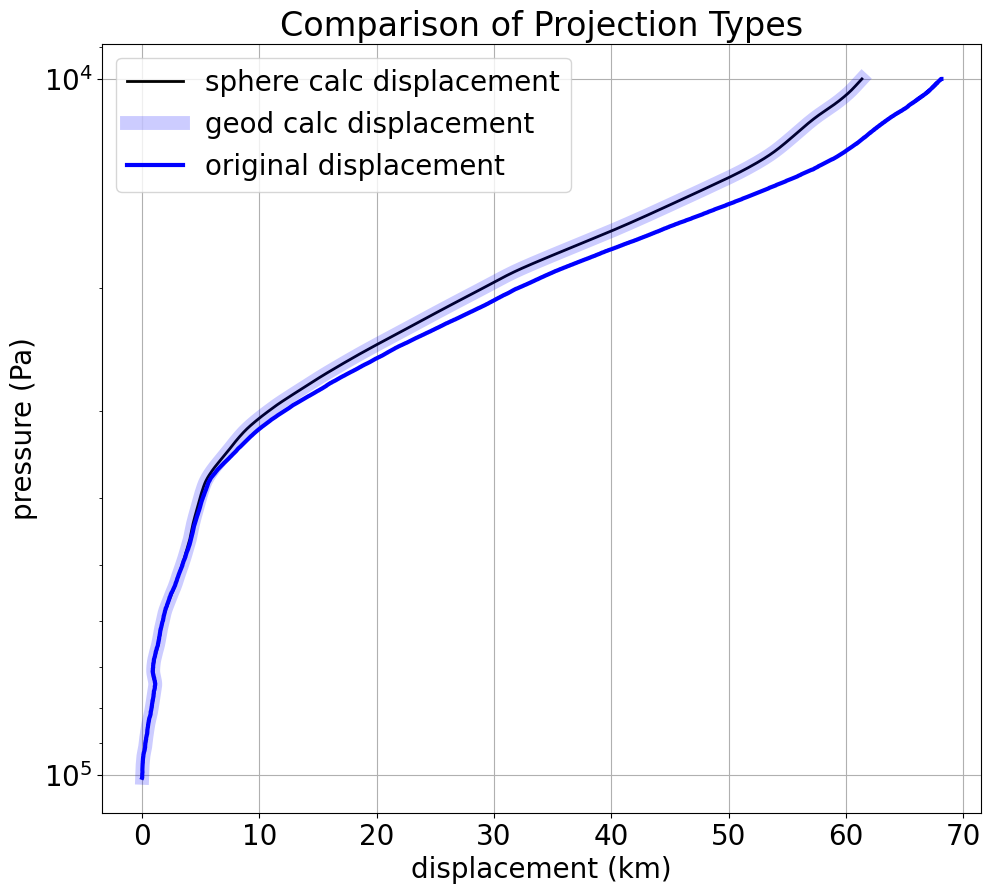

length of input data: 5234
significant levels: 25
lat:  25.92    lon:  -97.42
date:  20200531.0    time:  230400.0


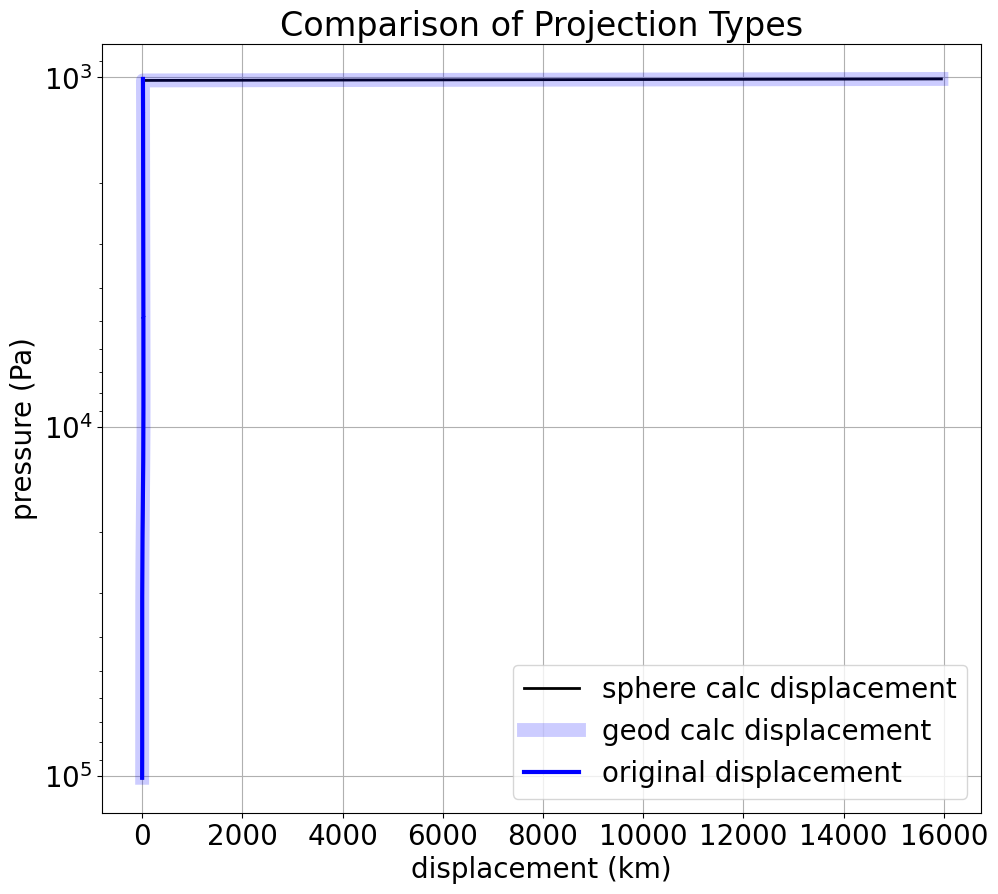

length of input data: 2409
significant levels: 21
lat:  53.010000000000005    lon:  -1.25
date:  20200531.0    time:  231500.0


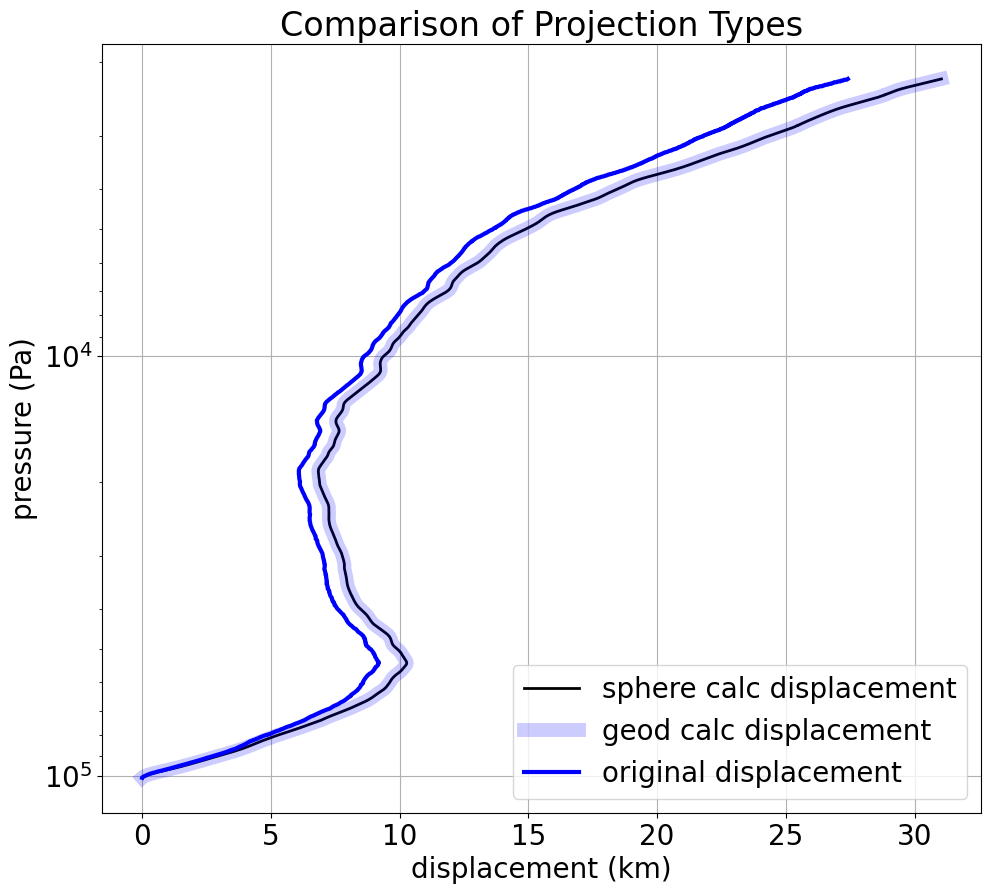

length of input data: 2160
significant levels: 13
lat:  49.690000000000005    lon:  7.330000000000001
date:  20200531.0    time:  224500.0


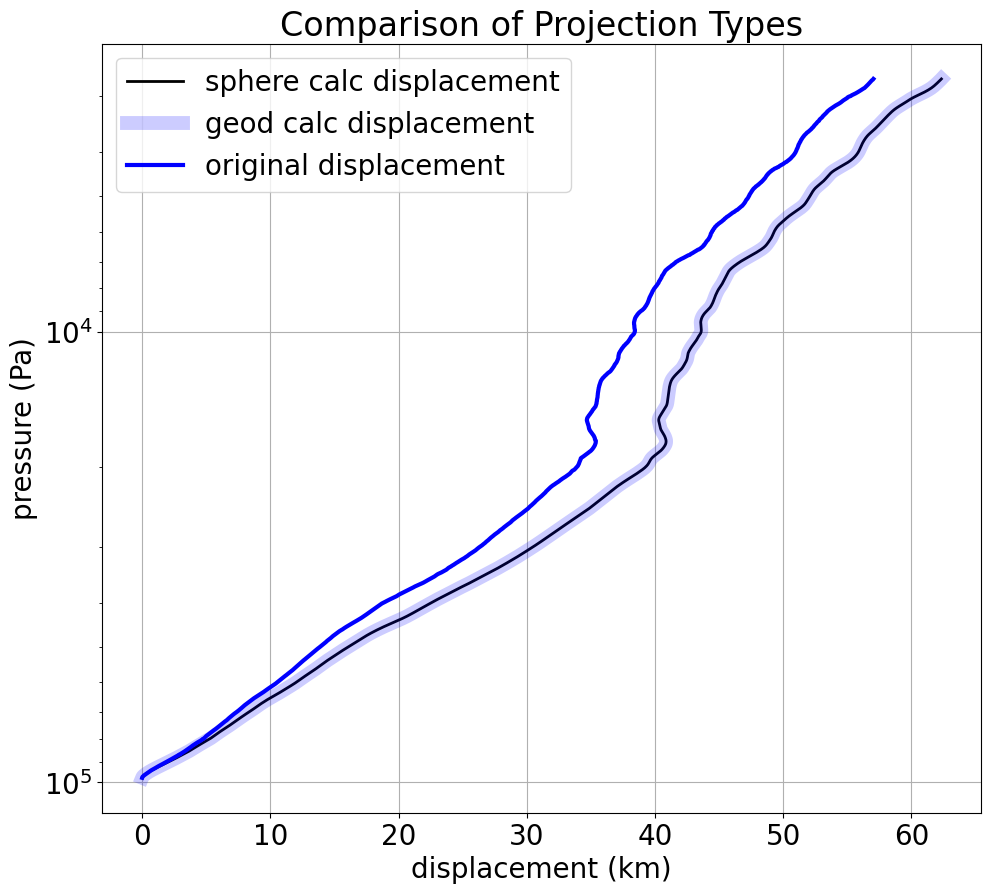

length of input data: 6097
significant levels: 37
lat:  36.25    lon:  -86.56
date:  20200531.0    time:  230000.0


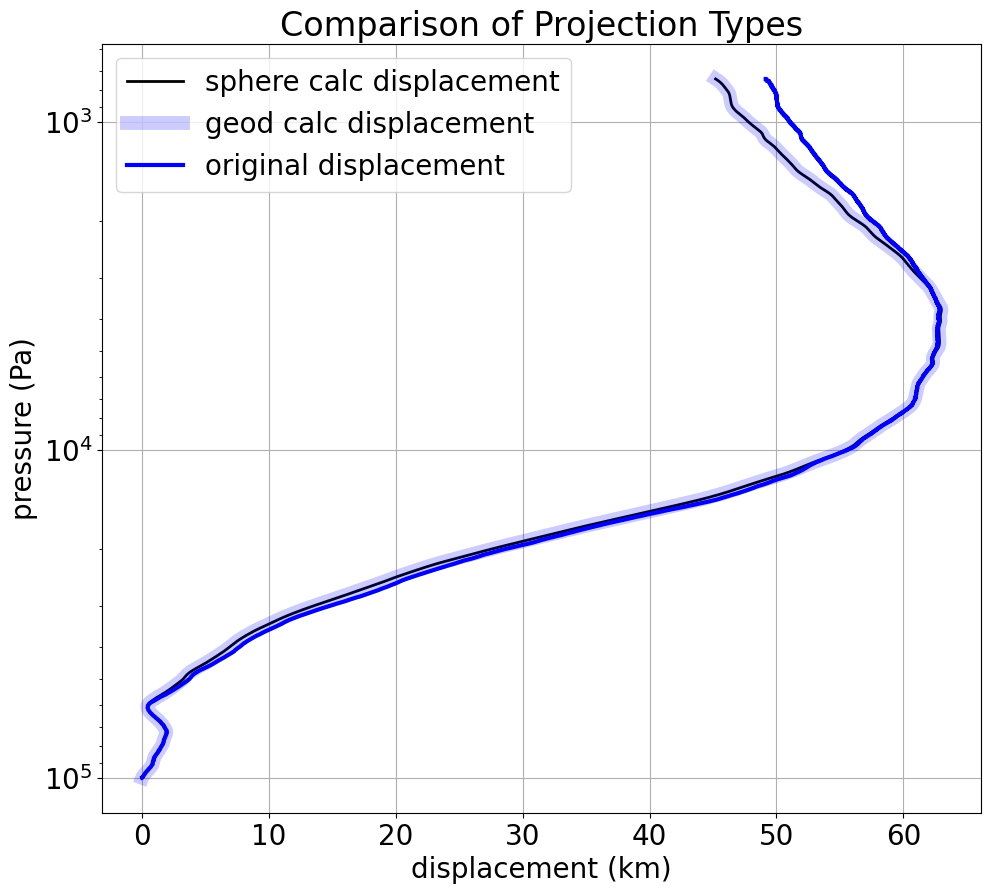

length of input data: 6372
significant levels: 46
lat:  57.150000000000006    lon:  -170.22000000000003
date:  20200531.0    time:  230100.0


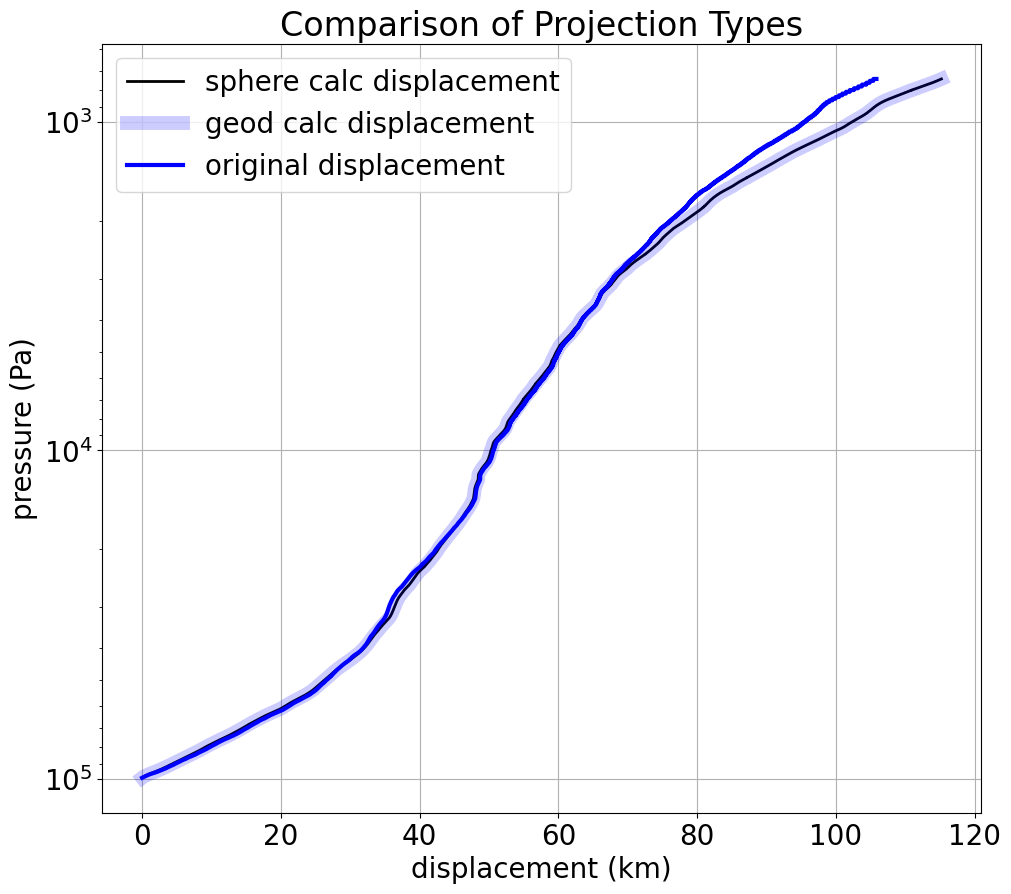

length of input data: 6156
significant levels: 32
lat:  33.36    lon:  -84.57000000000001
date:  20200531.0    time:  231400.0


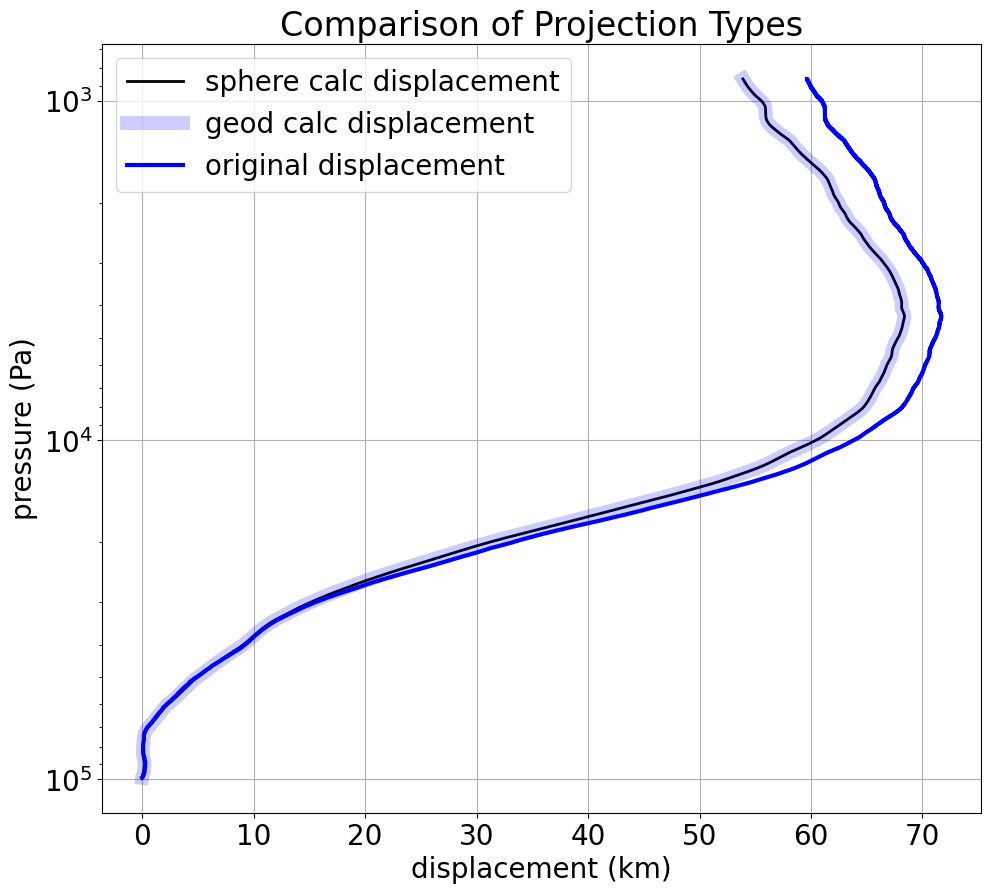

length of input data: 5978
significant levels: 33
lat:  32.45    lon:  -93.84
date:  20200531.0    time:  231600.0


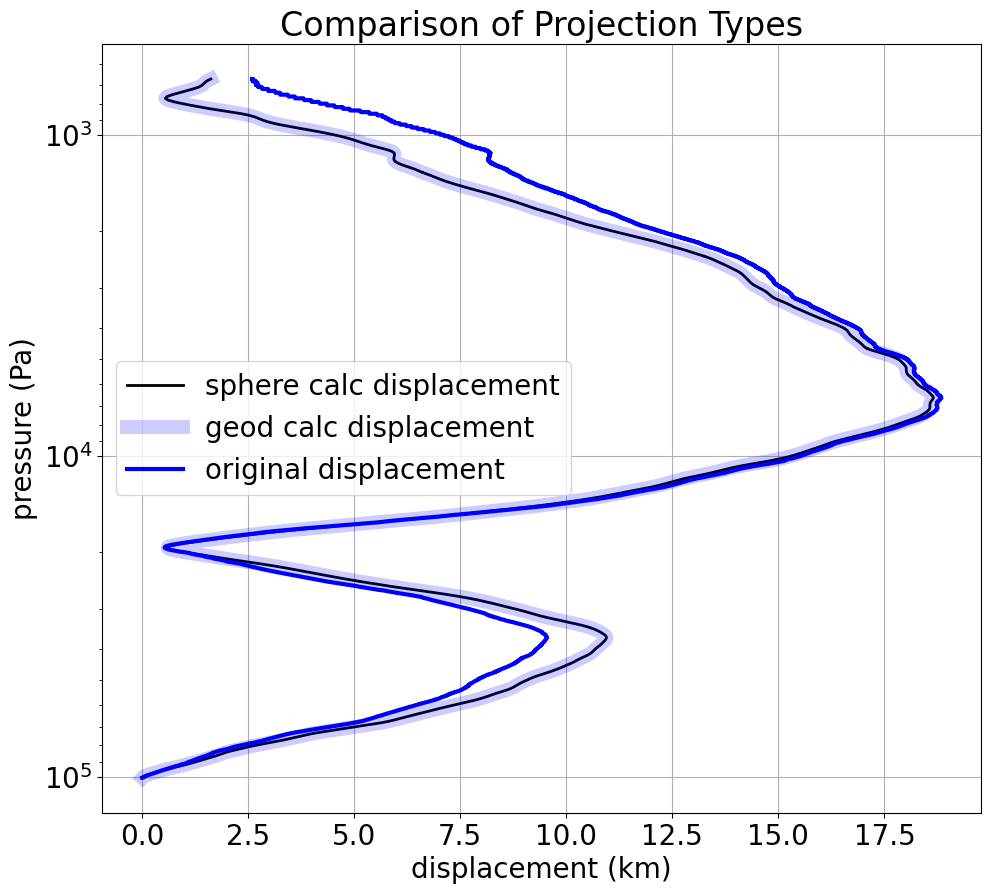

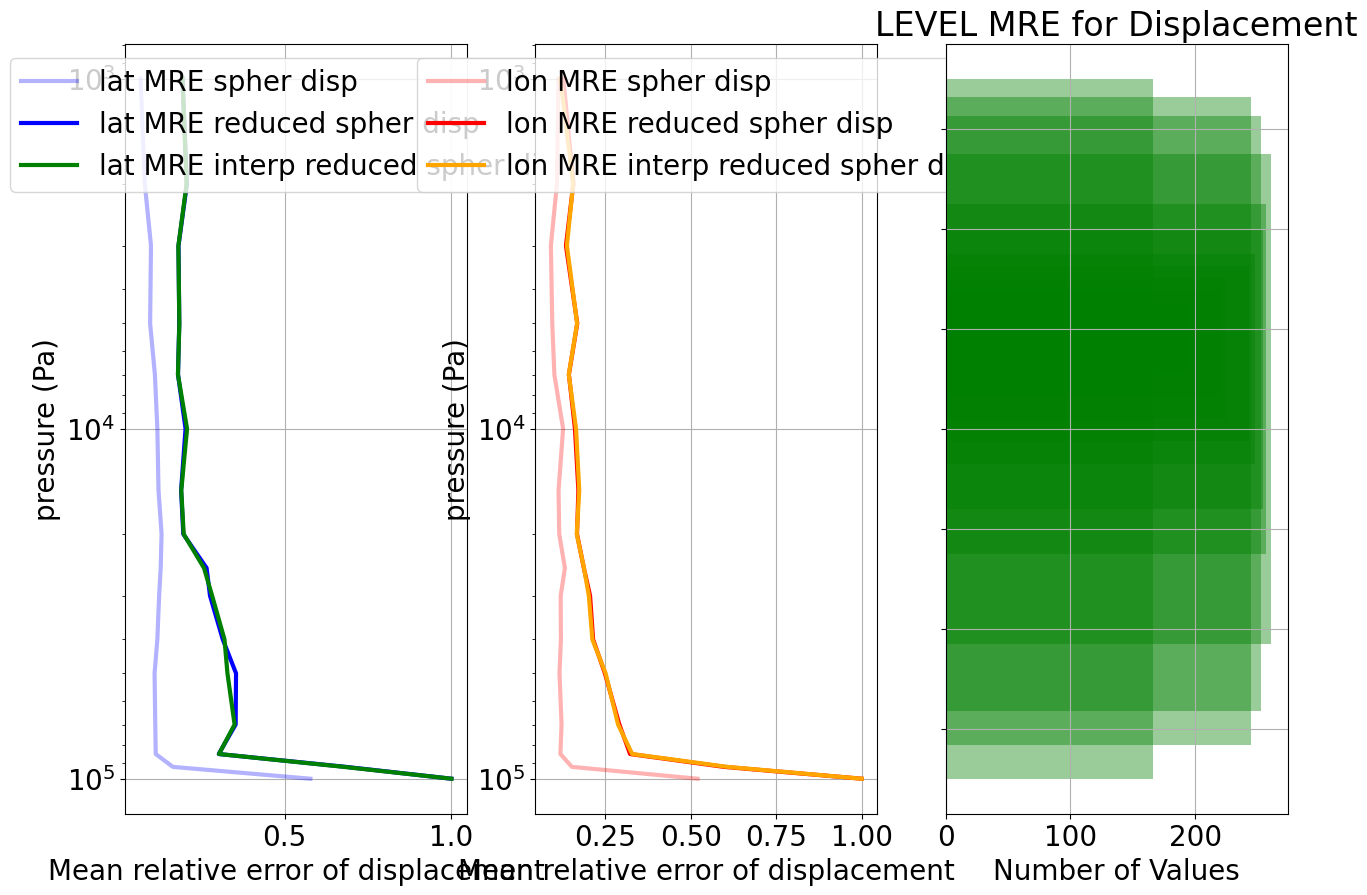

In [23]:
ipath=os.path.expanduser('~leo/ectrans/')
sodblist=glob.glob(ipath+'era5.bufr.202012')
sodblist.sort(key=os.path.getsize)
out = par_read_bufr_stn_nofeedback_mre_interp(111, sodblist[0]) #'./out.bufr')# sodblist[0])
